In [30]:
import numpy as np
import math
import Helper_functions as Hf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
from IPython.display import HTML
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable


%matplotlib inline

plt.rc('animation', html='html5')


plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  

#plt.ioff()

#### ND = nondimensional, the dimensionless parameters for the model ###

c22h = 9                            # ND 2nd baroclinic gravity wave speed squared
c12h = 10                           # ND 1st baroclinic gravity wave speed squared
H1H2 = 1                            # ND upper to lower layer height ratio
Bt = 1/2/(20**2) #(1**2)/2/(30**2)               # ND scaled beta Ld2^2/4a^2
Br2 = 1.5                           # ND scaled storm size: Burger number Ld2^2/Rst^2
p1p2 = 0.95                         # ND upper to lower layer density ratio
tstf = 48                           # ND storm duration tst*f0
tstpf= 60                           # ND period between forced storms tstp*f0
tradf= 2000                         # ND Newtonian damping of layer thickness trad*f0
Ar = 0.15                           # ND areal storm coverage
Re = 5e4                            # ND Reynolds number
Wsh = 0.05/2 #0.03/2                        # ND convective Rossby number


#### Derived Quantities ###

gm = p1p2*c22h/c12h*H1H2            # ND reduced gravity
aOLd = np.sqrt(1/Bt/2);             # ND planetary radius to deformation radius ratio
L = 3*np.pi/9*aOLd;                 # ND num = ceil(numfrc.*L.^2./Br2);
num = round(Ar*(L**2)*Br2/np.pi)    # number of storms
deglim = 90-3*L/2*aOLd*180/np.pi;   # domain size [degrees]

### Enginneering Params ###
  
AB = 2                             # Order of Adams-Bashforth scheme (2 or 3) 
layers = 2.5                        # number of layers (2 or 2.5)
n = 2                              # Order of Laplacian; '2' for hyperviscosity
kappa = 1e-6
ord = 2                             # Must equal 1 for Glenn's order, otherwise for Sadourney's
tmax = 10000
spongedrag1 = 0.1
spongedrag2 = 0.1



sims = 1 # number of simulations you want to run

In [2]:
EpHat = ((1/2)*p1p2*c12h + (1/2)*H1H2*c22h - p1p2*(c22h/c12h)*H1H2*c12h)*H1H2*(Wsh*tstf)**2 * (tradf/tstpf)* (Ar/np.sqrt(Br2))

print(f"EpHat: {EpHat}")
print(f"A/LD2: {aOLd}")

EpHat: 4.115142767875737
A/LD2: 20.0


In [3]:
"""
    Setting up parameters, this is the OEF_params file
"""
dx = 1/10  # L/N
dt = 1/(2**8)  # dx./(10.*c1)
dtinv = 1/dt
sampfreq = 10
tpl = sampfreq*dtinv

N = math.ceil(L/dx)  # ceil(10./9*pi*1./sqrt(Bt))
L = N*dx

l = np.concatenate((np.array([N]), np.arange(1, N)))
l2 = np.concatenate((np.arange(N-1, N+1), np.arange(1, N-1)))
r = np.concatenate((np.arange(2, N+1), np.array([1])))
r2 = np.concatenate((np.arange(3, N+1), np.arange(1, 3)))

# h B grid
x, y = np.meshgrid(np.arange(0.5, N)*dx-L/2, np.arange(0.5, N)*dx-L/2)
H = 1 + 0*x
eta = 0*x
h1 = 0*x + 1
h2 = 0*x + 1


# u grid
x, y = np.meshgrid(np.arange(0, N)*dx-L/2, np.arange(0.5, N)*dx-L/2)
u1 = 0*x*y
u2 = u1


# v grid
x, y = np.meshgrid(np.arange(0.5, N)*dx-L/2, np.arange(0, N)*dx-L/2)
v1 = 0*x*y
v2 = v1


# zeta grid
x, y = np.meshgrid(np.arange(0, N)*dx-L/2, np.arange(0, N)*dx-L/2)
rdist = np.sqrt(x**2 + y**2)
outerlim = L/2 - 0.5
rlim = (rdist <= outerlim).astype(float)


sponge1 = np.ones(N) * np.maximum(rdist - outerlim, 0)
sponge1 = sponge1 / np.max(sponge1)
spdrag1 = spongedrag1 * sponge1

sponge2 = np.ones(N) * np.maximum(rdist - outerlim, 0)
sponge2 = sponge2 / np.max(sponge2)
spdrag2 = spongedrag2 * sponge2

In [4]:
"""
    Setting up modes for the simulation, OEF_modes file

    TODO: Implement more than mode 1
"""

locs=Hf.paircountN2(num,N-1)
mode = 1

#locs = np.array([[79,125]])

match mode:

    case 1:
        pulse = 'off'

        wlayer = Hf.pairshapeN2(locs, x, y, Br2, Wsh, N, dx)
        Wmat = Hf.pairfieldN2(L, dx, h1, wlayer) 
        
        Wmatorig = Wmat
        
        tpulseper = tstpf
        tpulsedur = tstf
        tclock = 0

        FreeGrid = np.sum(spdrag1 == 0) / (N**2)



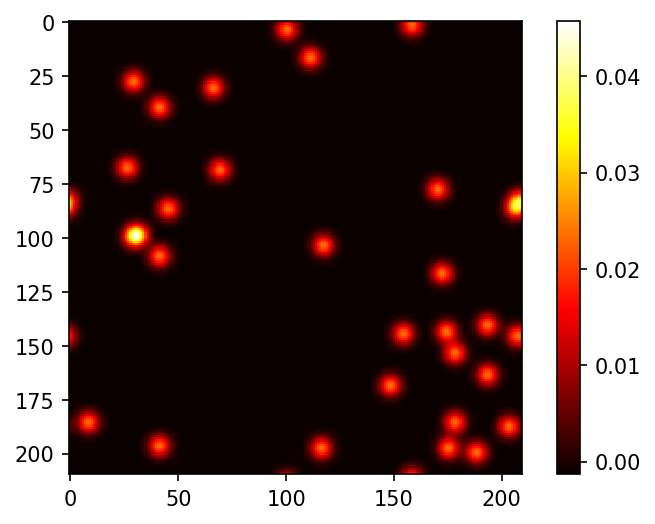

In [5]:
plt.imshow(Wmat, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

In [6]:

t = 0
tc = 0

# test
uhatvec = 0
del2psivec = 0
psi2vec = 0
CFL1vec = 0
CFL2vec = 0

# TIME STEPPING
if AB == 2:
    u1_p = u1.copy()
    v1_p = v1.copy()
    h1_p = h1.copy()
    u2_p = u2.copy()
    v2_p = v2.copy()
    h2_p = h2.copy()

if AB == 3:
    u1_p = np.zeros_like(u1)
    v1_p = np.zeros_like(v1)
    h1_p = np.zeros_like(h1)
    u2_p = np.zeros_like(u2)
    v2_p = np.zeros_like(v2)
    h2_p = np.zeros_like(h2)
    
    u1sq = np.zeros_like(u1)
    u2sq = np.zeros_like(u2) 
    v1sq = np.zeros_like(v1)
    v2sq = np.zeros_like(v2)

ts = []
hm = []  # height max min!
psi2 = np.zeros_like(x)
dhdt = psi2.copy()
pv1 = psi2.copy()
pv2 = psi2.copy()
zeta1 = psi2.copy()
zeta2 = psi2.copy()
B2 = psi2.copy()
B1p = B2.copy()
pv1 = B2.copy()
pv2 = B2.copy()


ii = 0
zeta1mat = []
zeta2mat = []
h1mat = []
h2mat = []
Wpulsemat = []
u1mat = []
u2mat = []
v1mat = []
v2mat = []

timer = time.time()

while t <= tmax + dt / 2:  

    if AB == 2:
        tmp = u1.copy()
        u1 = 1.5 * u1 - 0.5 * u1_p
        u1_p = tmp  #
        tmp = u2.copy()
        u2 = 1.5 * u2 - 0.5 * u2_p
        u2_p = tmp  #
        tmp = v1.copy()
        v1 = 1.5 * v1 - 0.5 * v1_p
        v1_p = tmp  
        tmp = v2.copy()
        v2 = 1.5 * v2 - 0.5 * v2_p
        v2_p = tmp  
        tmp = h1.copy()
        h1 = 1.5 * h1 - 0.5 * h1_p
        h1_p = tmp
        if layers == 2.5:
            tmp = h2.copy()
            h2 = 1.5 * h2 - 0.5 * h2_p
            h2_p = tmp

    if AB == 3:
        if tc > 1:
            u1s = u1.copy()
            u1 = 23 / 12 * u1 - 16 / 12 * u1_p + 5 / 12 * u1_pp
            u1_pp = u1_p.copy()
            u1_p = u1s.copy()
            v1s = v1.copy()
            v1 = 23 / 12 * v1 - 16 / 12 * v1_p + 5 / 12 * v1_pp
            v1_pp = v1_p.copy()
            v1_p = v1s.copy()
            h1s = h1.copy()
            h1 = 23 / 12 * h1 - 16 / 12 * h1_p + 5 / 12 * h1_pp
            h1_pp = h1_p.copy()
            h1_p = h1s.copy()
            u2s = u2.copy()
            u2 = 23 / 12 * u2 - 16 / 12 * u2_p + 5 / 12 * u2_pp
            u2_pp = u2_p.copy()
            u2_p = u2s.copy()
            v2s = v2.copy()
            v2 = 23 / 12 * v2 - 16 / 12 * v2_p + 5 / 12 * v2_pp
            v2_pp = v2_p.copy()
            v2_p = v2s.copy()
            if layers == 2.5:
                h2s = h2.copy()
                h2 = 23 / 12 * h2 - 16 / 12 * h2_p + 5 / 12 * h2_pp
                h2_pp = h2_p.copy()
                h2_p = h2s.copy()

    # add friction
    du1dt = Hf.viscND(u1, Re, n, dx)    
    du2dt = Hf.viscND(u2, Re, n, dx)
    dv1dt = Hf.viscND(v1, Re, n, dx)
    dv2dt = Hf.viscND(v2, Re, n, dx)
    
    if spongedrag1 > 0:
        du1dt = du1dt - spdrag1 * (u1)
        du2dt = du2dt - spdrag2 * (u2)
        dv1dt = dv1dt - spdrag1 * (v1)
        dv2dt = dv2dt - spdrag2 * (v2)

    # absolute vorticity
    zeta1 = 1 - Bt * rdist ** 2 + (1 / dx) * (v1 - np.roll(v1, 1, axis=1) + np.roll(u1, 1, axis=0) - u1)  
    zeta2 = 1 - Bt * rdist ** 2 + (1 / dx) * (v2 - np.roll(v2, 1, axis=1) + np.roll(u2, 1, axis=0) - u2)  

    # add vorticity flux, zeta*u
    zv1 = zeta1 * (v1 + np.roll(v1, 1, axis=1))
    zv2 = zeta2 * (v2 + np.roll(v2, 1, axis=1))

    du1dt = du1dt + 0.25 * (zv1 + np.roll(zv1, -1, axis=0))
    du2dt = du2dt + 0.25 * (zv2 + np.roll(zv2, -1, axis=0))

    zu1 = zeta1 * (u1 + np.roll(u1, 1, axis=0))
    zu2 = zeta2 * (u2 + np.roll(u2, 1, axis=0))

    dv1dt = dv1dt - 0.25 * (zu1 + np.roll(zu1, -1, axis=1))
    dv2dt = dv2dt - 0.25 * (zu2 + np.roll(zu2, -1, axis=1))


    B1p, B2p = Hf.BernN2(u1, v1, u2, v2, gm, c22h, c12h, h1, h2, ord, r)

    du1dtsq = du1dt - (1 / dx) * (B1p - np.roll(B1p, 1, axis=1))  
    du2dtsq = du2dt - (1 / dx) * (B2p - np.roll(B2p, 1, axis=1))  

    dv1dtsq = dv1dt - (1 / dx) * (B1p - np.roll(B1p, 1, axis=0))  
    dv2dtsq = dv2dt - (1 / dx) * (B2p - np.roll(B2p, 1, axis=0))  
    
    if AB == 2:
        u1sq = u1_p + dt * du1dtsq
        u2sq = u2_p + dt * du2dtsq

        v1sq = v1_p + dt * dv1dtsq
        v2sq = v2_p + dt * dv2dtsq

    if mode == 1:
        if t % tpulseper == 0 and t != 0:
            tclock = t
            locs = Hf.paircountN2(num, N-1)
            wlayer = Hf.pairshapeN2(locs, x, y, Br2, Wsh, N, dx)
            newWmat = Hf.pairfieldN2(L, dx, h1, wlayer)

        if tclock + tpulsedur > t and tclock != 0:
            Wmat = newWmat
        elif t > tpulsedur:
            Wmat = np.zeros_like(x * y)
            tclock = 0

    Fx1 = Hf.xflux(h1, u1, dx, dt) - kappa / dx * (h1 - np.roll(h1, 1, axis=1))
    Fy1 = Hf.yflux(h1, v1, dx, dt) - kappa / dx * (h1 - np.roll(h1, 1, axis=0))
    dh1dt = -(1 / dx) * (np.roll(Fx1, -1, axis=1) - Fx1 + np.roll(Fy1, -1, axis=0) - Fy1)

    if layers == 2.5:
        Fx2 = Hf.xflux(h2, u2, dx, dt) - kappa / dx * (h2 - np.roll(h2, 1, axis=1))
        Fy2 = Hf.yflux(h2, v2, dx, dt) - kappa / dx * (h2 - np.roll(h2, 1, axis=0))
        dh2dt = -(1 / dx) * (np.roll(Fx2, -1, axis=1) - Fx2 + np.roll(Fy2, -1, axis=0) - Fy2)

    if tradf > 0:
        dh1dt = dh1dt - 1 / tradf * (h1 - 1)
        dh2dt = dh2dt - 1 / tradf * (h2 - 1)
    
    if mode == 1:
        dh1dt = dh1dt + Wmat
        if layers == 2.5:
            dh2dt = dh2dt - H1H2 * Wmat
            
    if AB == 3:  
        if tc >= 1:  
            du1dt1 = u1sq + dt * du1dtsq  
            du2dt1 = u2sq + dt * du2dtsq  
            dv1dt1 = v1sq + dt * dv1dtsq
            dv2dt1 = v2sq + dt * dv2dtsq
            dh1dt1 = h1 + dt * dh1dt
            if layers == 2.5:
                dh2dt1 = h2 + dt * dh2dt

            u1_pp = u1_p.copy()
            u1_p = u1.copy()
            v1_pp = v1_p.copy()
            v1_p = v1.copy()
            u2_pp = u2_p.copy()
            u2_p = u2.copy()
            v2_pp = v2_p.copy()
            v2_p = v2.copy()
            h1_pp = h1_p.copy()
            h1_p = h1.copy()
            if layers == 2.5:
                h2_pp = h2_p.copy()
                h2_p = h2.copy()

            u1sq = u1sq + dt / 2 * (du1dtsq + du1dt1)  
            u2sq = u2sq + dt / 2 * (du2dtsq + du2dt1)
            v1sq = v1sq + dt / 2 * (dv1dtsq + dv1dt1)
            v2sq = v2sq + dt / 2 * (dv2dtsq + dv2dt1)
            h1 = h1 + dt / 2 * (dh1dt + dh1dt1)
            if layers == 2.5:
                h2 = h2 + dt / 2 * (dh2dt + dh2dt1)

        else:
            h1 = h1_p + dt * dh1dt
            if layers == 2.5:
                h2 = h2_p + dt * dh2dt

    if AB == 2:
        h1 = h1_p + dt * dh1dt
        if layers == 2.5:
            h2 = h2_p + dt * dh2dt
            # eta = (g31.*h1+g32.*h2)./g;

    u1 = u1sq
    u2 = u2sq
    v1 = v1sq
    v2 = v2sq
        
    if tc % tpl == 0:
        print(f't={t}, mean h1 is {round(np.mean(np.mean(h1)), 4)}. Time elapsed, {round(time.time()-timer, 3)}s')
        ii += 1
        ts.append(t)
    
        u1mat.append(u1)
        u2mat.append(u2)
        v1mat.append(v1)
        v2mat.append(v2)
        h1mat.append(h1)
        h2mat.append(h2)
        zeta1mat.append(zeta1)
        zeta2mat.append(zeta2)
        
        #Wpulsemat.append(Wmat)

        timer = time.time()

    if math.isnan(h1[0,0]):
        break

    tc += 1
    t = tc*dt


t=0, mean h1 is 1.0. Time elapsed, 0.016s
t=10.0, mean h1 is 1.0. Time elapsed, 18.232s
t=20.0, mean h1 is 1.0. Time elapsed, 15.414s
t=30.0, mean h1 is 1.0. Time elapsed, 15.705s
t=40.0, mean h1 is 1.0. Time elapsed, 16.343s
t=50.0, mean h1 is 1.0. Time elapsed, 17.917s
t=60.0, mean h1 is 1.0. Time elapsed, 18.252s
t=70.0, mean h1 is 1.0. Time elapsed, 15.853s
t=80.0, mean h1 is 1.0. Time elapsed, 15.262s
t=90.0, mean h1 is 1.0. Time elapsed, 15.38s
t=100.0, mean h1 is 1.0. Time elapsed, 15.579s
t=110.0, mean h1 is 1.0. Time elapsed, 17.953s
t=120.0, mean h1 is 1.0. Time elapsed, 15.729s
t=130.0, mean h1 is 1.0. Time elapsed, 17.138s
t=140.0, mean h1 is 1.0. Time elapsed, 18.568s
t=150.0, mean h1 is 1.0. Time elapsed, 19.563s
t=160.0, mean h1 is 1.0. Time elapsed, 18.7s
t=170.0, mean h1 is 1.0. Time elapsed, 17.655s
t=180.0, mean h1 is 1.0. Time elapsed, 18.017s
t=190.0, mean h1 is 1.0. Time elapsed, 18.464s
t=200.0, mean h1 is 1.0. Time elapsed, 18.186s
t=210.0, mean h1 is 1.0. Time 

C:\Users\stedm\AppData\Local\Temp\ipykernel_4592\1348043185.py:128: RuntimeWarning: overflow encountered in multiply
  zv1 = zeta1 * (v1 + np.roll(v1, 1, axis=1))
C:\Users\stedm\AppData\Local\Temp\ipykernel_4592\1348043185.py:129: RuntimeWarning: overflow encountered in multiply
  zv2 = zeta2 * (v2 + np.roll(v2, 1, axis=1))
C:\Users\stedm\AppData\Local\Temp\ipykernel_4592\1348043185.py:131: RuntimeWarning: invalid value encountered in add
  du1dt = du1dt + 0.25 * (zv1 + np.roll(zv1, -1, axis=0))
C:\Users\stedm\AppData\Local\Temp\ipykernel_4592\1348043185.py:132: RuntimeWarning: invalid value encountered in add
  du2dt = du2dt + 0.25 * (zv2 + np.roll(zv2, -1, axis=0))
C:\Users\stedm\AppData\Local\Temp\ipykernel_4592\1348043185.py:134: RuntimeWarning: overflow encountered in multiply
  zu1 = zeta1 * (u1 + np.roll(u1, 1, axis=0))
C:\Users\stedm\AppData\Local\Temp\ipykernel_4592\1348043185.py:135: RuntimeWarning: overflow encountered in multiply
  zu2 = zeta2 * (u2 + np.roll(u2, 1, axis=0)

In [ ]:
plt.imshow(u1mat[10], cmap='hot')
plt.colorbar()
plt.show()

In [7]:
PV2 = zeta2mat - (1 - Bt * rdist ** 2)

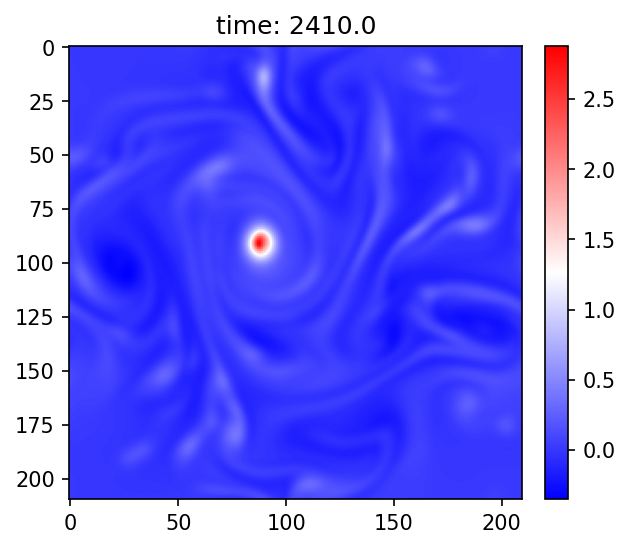

In [35]:
frames = PV2


fig = plt.figure()
ax = fig.add_subplot(111)
div = make_axes_locatable(ax)
cax = div.append_axes('right', '5%', '5%')

cv0 = frames[0]
im = ax.imshow(cv0, cmap='bwr')
cb = fig.colorbar(im, cax=cax)
tx = ax.set_title(f'time: {ts[0]}')

def animate(i):
    arr = frames[i]
    
    vmax     = np.max(arr)
    vmin     = np.min(arr)
    im.set_data(arr)
    im.set_clim(vmin, vmax)
    tx.set_text(f'time: {ts[i]}')


ani = animation.FuncAnimation(fig, animate, interval=100, frames=len(frames))

HTML(ani.to_html5_video())